In [1]:
# -- LOG -- #
import logging as log
log.basicConfig(filename='./Logs/simonyan_1.log',
                filemode='w',
                format='[%(asctime)s]:[%(name)s]:(%(levelname)s): %(message)s',
                level=log.INFO)

In [2]:
# -- IMPORTS -- #
try:
    from keras.applications.vgg16 import VGG16
    from keras.applications.vgg16 import preprocess_input, decode_predictions
    from keras.preprocessing import image as kerasImage
    from PIL import Image as pilImage
    from tqdm import tqdm
    %matplotlib inline
    import matplotlib.pyplot as plt
    import keras.backend as K
    import imageio
    import subprocess
    import numpy as np
    import os
except Exception as e:
    log.error('Failed -- IMPORT:\n',exc_info=True)
    raise SystemExit(0)

Using TensorFlow backend.


In [3]:
# -- DEFINE MODEL -- #
vgg16Model = VGG16(weights='imagenet',include_top=True)
layerOutputs = {}
for layer in vgg16Model.layers:
    layer.trainable = False
    if layer.__class__.__name__ == 'Conv2D':
        layerOutputs[layer.name]=layer.output
imgInput = vgg16Model.inputs[0]
log.info('Model Loaded')
vgg16Model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [4]:
# -- DEFINE FUNCTIONS -- #
def deprocess_image(x):    
    x -= x.mean(); x /= (x.std() + K.epsilon()); x *= 0.25
    # CLIP DATA
    x += 0.5; x = np.clip(x, 0, 1)
    # CONVERT TO RGB
    x *= 255; x = np.clip(x, 0, 255).astype('uint8')
    return x

def process_image(x,previous):
    # NORMALIZE / CENTERING
    x = x/255; x -= 0.5
    # ADD PREVIOUS STD AND MEAN
    return x*4*previous.std()+previous.mean()

Select the number of iterations: 30


block1_conv1
block1_conv2
block2_conv1
block2_conv2
block3_conv1
block3_conv2
block3_conv3
block4_conv1
block4_conv2
block4_conv3
block5_conv1
block5_conv2
block5_conv3


Select the layer: block5_conv3
Select the filter you want to maximize (0-511) 257


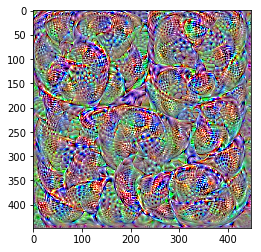

In [21]:
# -- ACTIVATION MAXIMIZATION FOR ONE FILTER OF A SPECIFIC LAYER -- #
if not os.path.isdir('./Results/Simonyan1'):
    os.mkdir('./Results/Simonyan1')
    log.info('Directory created.')
    
# -- DEFINE HYPERPARAMETERS -- #
targetSize = 448
factor = 1.2
upSteps = 9

# -- SELECT LAYER AND FILTER -- #
epochs = int(input('Select the number of iterations:'))
for key in layerOutputs:
    print(key)
name = input('Select the layer:')
layer = layerOutputs[name]
numFilters = layer.shape[-1]
filt = int(input('Select the filter you want to maximize (0-{0})'.format(numFilters-1)))
gifImg = []

# -- DEFINE LOSS & GRADIENT -- #
loss = K.mean(layer[:,:,:,filt])
grads = K.gradients(loss,imgInput)[0]
grads /= K.sqrt(K.mean(K.square(grads)))+1e-8
iterate = K.function([imgInput],[loss,grads])
size = int(targetSize/(factor**upSteps))
imgInputData = np.random.normal(0,10,(1,size,size,3))

# -- START ITERATION -- #
log.info('Starting Iterations')
gifImg.append(imgInputData[0].copy())
for up in reversed(range(upSteps)):
    for k in range(epochs):
        lossVal,gradVal = iterate([imgInputData])
        if lossVal <= K.epsilon():
            log.info('Filter: '+str(filt)+' Stuck with gradient 0.')
            break
        step = 1/(gradVal.std()+1e-8)
        imgInputData += gradVal*step
        gifImg.append(imgInputData[0].copy())
        log.info('Current loss value:'+str(lossVal))
    size = int(targetSize/(factor**up))
    # CONVERT TO VALID IMAGE
    img = deprocess_image(imgInputData[0])
    # RESIZE
    img = np.asarray(pilImage.fromarray(img).resize((size,size),pilImage.BILINEAR),dtype='float32')
    # CONVERT AGAIN TO FLOAT
    imgInputData = [process_image(img,imgInputData[0])]
    
# -- SAVE RESULTS -- #
img = deprocess_image(imgInputData[0])
log.info('Saving Final Image. Size:'+str(img.shape))
plt.imshow(img)
plt.show()
img = kerasImage.array_to_img(img,scale=False)
img.save('./Results/Simonyan1/'+name+'_'+str(filt)+'.png',dpi=(250,250))

In [19]:
# -- CREATE GIF -- #
log.info('Creating GIF of '+str(len(gifImg))+' Images.')
size = int(targetSize/2) 
with imageio.get_writer('./Results/Simonyan1/'+name+'_'+str(filt)+'.gif', mode='I') as writer:
    for im in gifImg:
        image = deprocess_image(im.copy())
        image = np.asarray(pilImage.fromarray(image).resize((size,size),pilImage.ANTIALIAS))
        writer.append_data(image)
log.info('DONE')

In [20]:
# -- DRAW MOSAIC OF PROGRESS -- #
margin = 5
stop = False
size = int(targetSize/2) 
mosaic = []
for im in gifImg[0::int(epochs/2)]:
    image = deprocess_image(im.copy())
    mosaic.append(np.asarray(pilImage.fromarray(image).resize((size,size),pilImage.ANTIALIAS)))
n = int(np.round(np.sqrt(len(mosaic))))
cols = size*n+(n-1)*margin
rows = size*n+(n-1)*margin
draw = np.zeros((cols,rows,3),dtype='uint8')
log.info('The dimensions of the Mosaic are: '+str(draw.shape))
im = 0
for c in range(n):
    if not stop:
        for r in range(n):
            wM = (size+margin)*c
            hM = (size+margin)*r
            draw[wM:wM+size,hM:hM+size,:] = mosaic[im]
            im += 1
            if(im >= len(mosaic)):
                stop = True
                break
    else:
        break
imgDraw = kerasImage.array_to_img(draw,scale=False)
imgDraw.save('./Results/Simonyan1/Mosaic_'+name+'_'+str(filt)+'.png',dpi=(250,250))
log.info('DONE')